In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing


colors = ['red', 'green']
feature_list = ['created_at', 'id', 'full_text', 'user', 'retweet_count', 'favorite_count', 'coordinates', 'place', 'class']

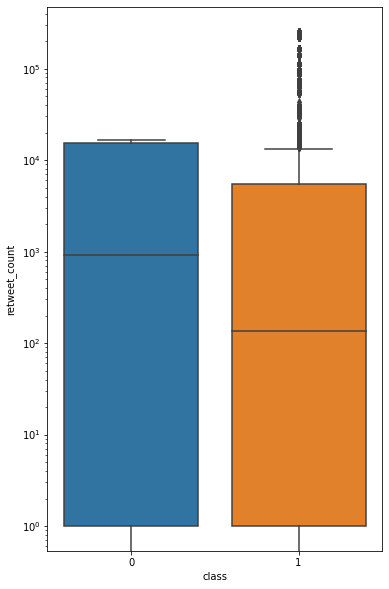

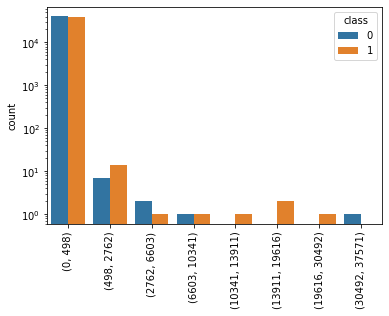

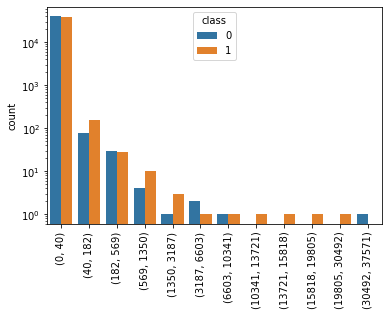

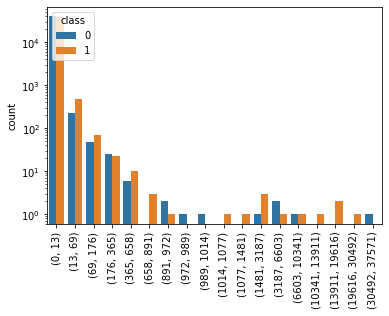

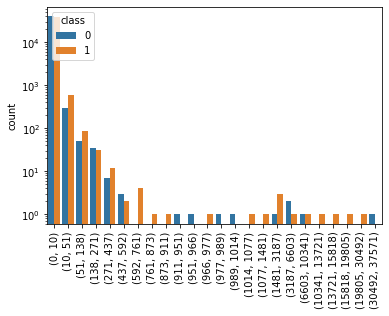

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [43]:
training_set = pd.read_json('development.jsonl', lines=True)
training_set = training_set[feature_list]

#test_set = pd.read_json('evaluation.jsonl', lines=True)
#test_set = test_set[feature_list]

In [61]:
n_positive = training_set.loc[training_set['class'] == 1, 'class'].count()
n_negative = training_set.loc[training_set['class'] == 0, 'class'].count()

n_null_coord = training_set['coordinates'].isna().sum()
n_null_place = training_set['place'].isna().sum()

# number of tweets with 0 as 'favorite_count'
n_pos_favcount = training_set.loc[(training_set['class'] == 0) & (training_set['favorite_count'] == 0), 'favorite_count'].count() / len(training_set) * 100
n_neg_favcount = training_set.loc[(training_set['class'] == 1) & (training_set['favorite_count'] == 0), 'favorite_count'].count() / len(training_set) * 100

median_neg_retweet = training_set.loc[training_set['class'] == 0, 'retweet_count'].median()
median_pos_retweet = training_set.loc[training_set['class'] == 1, 'retweet_count'].median()

median_neg_favcount = training_set.loc[training_set['class'] == 0, 'favorite_count'].median()
median_pos_favcount = training_set.loc[training_set['class'] == 1, 'favorite_count'].median()

print("Number of positive  tweets: {} ({:.2f}%), number of negative tweets: {} ({:.2f}%)".format(n_positive, n_positive / len(training_set) * 100, n_negative,  n_negative / len(training_set) * 100,))
print("Percentage of null coordinates: {:.2f}%, percentage of null places: {:.2f}%".format(n_null_coord / len(training_set) * 100, n_null_place / len(training_set) * 100))
print("Percentage of tweets with 0 as 'favorite_count': {:.2f}% ({:.2f}% positive tweets - median at {:.2f}, {:.2f}% negative tweets - median at {:.2f})".format(n_pos_favcount + n_neg_favcount, n_pos_favcount, median_pos_favcount, n_neg_favcount, median_neg_favcount))
print("Median of positive retweet count: {:.0f}, median of negative retweet count: {:.0f}".format(median_pos_retweet, median_neg_retweet))

(6.215, 6.951250000000001)

In [ ]:
fig, ax = plt.subplots(figsize=(6,10))
g = sns.boxplot('class', 'retweet_count', data=training_set)
g.set_yscale('log')
plt.show()

n_bins = [8, 12, 18, 24]

for n in n_bins:
    discretizer = preprocessing.KBinsDiscretizer(n_bins=n, encode='ordinal', strategy='kmeans')
    X_binned = discretizer.fit_transform(fav_count)
    X_binned = np.reshape(X_binned, len(X_binned))

    ranges = []
    for i in range(len(discretizer.bin_edges_[0]) - 1):
        item = (int(discretizer.bin_edges_[0][i]), int(discretizer.bin_edges_[0][i+1]))
        ranges.append(item)

    g = sns.countplot(X_binned, hue='class', data=training_set)
    g.set_yscale('log')
    g.set_xticklabels(ranges, rotation=90)
    plt.show()